In [1]:
EXPORT_PATH = '../data/processed/'
DATA_PATH = '../data/raw/'

target_col= ['DevType']
influnce_col = ['LanguageWorkedWith',
                  'DatabaseWorkedWith',
                  'WebframeWorkedWith',
                  'MiscTechWorkedWith',]


In [2]:
import pandas as pd 
import numpy as np
import logging
import pickle
import os
import seaborn as sns
import plotly 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram



In [3]:
df =pd.read_pickle(EXPORT_PATH+'1_preprocessed.pkl')


## One Hot Encoding

In [4]:
ml = MultiLabelBinarizer()
encode_df = {}
for col in target_col + influnce_col:
    encoded = ml.fit_transform(df[col])
    df_encoded = pd.DataFrame(encoded, columns=ml.classes_)
    
    encode_df[col] = df_encoded
    
    ohe_df = pd.concat(encode_df, axis=1)

In [5]:
sorted_roles = ohe_df['DevType'].sum().sort_values(ascending=False).index.tolist()
sorted_roles

['Developer, back-end',
 'Developer, full-stack',
 'Developer, front-end',
 'Developer, desktop or enterprise applications',
 'Developer, mobile',
 'DevOps specialist',
 'Database administrator',
 'Designer',
 'System administrator',
 'Developer, embedded applications or devices',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Developer, QA or test',
 'Engineer, data',
 'Academic researcher',
 'Educator',
 'Developer, game or graphics',
 'Engineering manager',
 'Product manager',
 'Scientist',
 'Engineer, site reliability',
 'Senior executive/VP',
 'Marketing or sales professional']

In [6]:
skills =[]
for role in sorted_roles:
    role_mask = (ohe_df['DevType'][role] == 1)
    skills_role = pd.concat({tech_col: ohe_df.loc[role_mask,tech_col].mean() * 100
                             for tech_col in influnce_col})    
    skills.append(skills_role)
    
skills_df = pd.DataFrame(skills, index=sorted_roles)
skills_df = skills_df.T
skills_df.reset_index(0,drop=True,inplace=True)
final_df = skills_df.T

## Dimensionality reduction

In [7]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

st = StandardScaler()
std_final_df = st.fit_transform(final_df)

std_final_df = pd.DataFrame(std_final_df, index=final_df.index, columns=final_df.columns)

pca = PCA(n_components=20, random_state=42, svd_solver='full')
pca_final_df = pca.fit_transform(std_final_df.T)

pca_final_df = pd.DataFrame(pca_final_df, index=final_df.columns)

pca.explained_variance_ratio_.cumsum()

array([0.34662718, 0.54602742, 0.67104211, 0.7757216 , 0.84898746,
       0.89824596, 0.92652287, 0.94779761, 0.96260189, 0.97336835,
       0.98074629, 0.98589707, 0.98918125, 0.99200595, 0.99413453,
       0.99591327, 0.99717967, 0.99812399, 0.9989084 , 0.99949256])

In [8]:
pca_final_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Assembly,1.895473,2.816718,-0.794881,0.266319,2.724708,-0.977496,0.068127,-0.865236,0.178371,1.277137,0.168260,0.174983,0.127263,0.111413,-0.328882,0.180203,0.080796,-0.119276,-0.038596,-0.023782
Bash/Shell/PowerShell,2.073694,-2.593689,0.006060,1.374805,1.736357,0.274544,-1.211820,-0.517316,-0.502586,0.117453,-0.094034,-0.174940,0.453469,-0.011238,0.571496,-0.256706,0.165639,-0.005530,0.100773,-0.083915
C,2.135053,3.265204,-0.183170,1.379012,2.161179,-1.052924,-0.609153,-1.463546,0.295429,1.303075,0.548644,-0.158757,-0.076906,-0.043183,-0.213681,-0.265275,0.041939,-0.229466,-0.116337,-0.091050
C#,-2.798604,1.364297,2.403346,2.479237,1.517486,-0.716906,0.297893,0.939654,-0.215099,-0.197384,-0.160924,0.053794,-0.131156,0.171781,0.082374,0.155807,-0.001824,0.092178,-0.040143,0.095128
C++,2.066030,3.705348,-0.037518,1.859284,1.956906,-1.540200,-0.463406,-0.694408,0.201126,0.610659,0.313576,0.025079,-0.162411,0.028424,-0.157274,-0.129653,0.104401,0.017513,-0.069948,0.055444


In [9]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(pca_final_df)

tsne_projection = pd.DataFrame(tsne_projection, index=final_df.columns)

In [10]:
tsne_projection.columns = ['Dimension 1', 'Dimension 2']
tsne_projection

,Dimension 1,Dimension 2
Assembly,8.706415,2.230735
Bash/Shell/PowerShell,9.093084,-10.156259
C,9.122461,3.380812
C#,-19.979429,15.200497
C++,8.199023,3.859507
...,...,...
Teraform,8.627229,-7.247944
Torch/PyTorch,30.448118,14.283766
Unity 3D,2.462782,11.130984
Unreal Engine,3.081114,10.710283


In [11]:
fig = px.scatter(x=tsne_projection['Dimension 1'], y=tsne_projection['Dimension 2'], text=tsne_projection.index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1200, width=1200, title_text='TSNE')
fig.show()

## Cluster

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
scores = []
best_model = 0
for i in range(5,25):
    cluster = KMeans(n_clusters=i, random_state=42,init='k-means++', n_init=10)
    cluster.fit(tsne_projection)
    pred = cluster.predict(tsne_projection)
    scores.append(silhouette_score(tsne_projection, pred))
    
    if silhouette_score(tsne_projection, pred) > best_model:
        best_model = silhouette_score(tsne_projection, pred)
        best_cluster = cluster
        


In [13]:
best_cluster.n_clusters

13

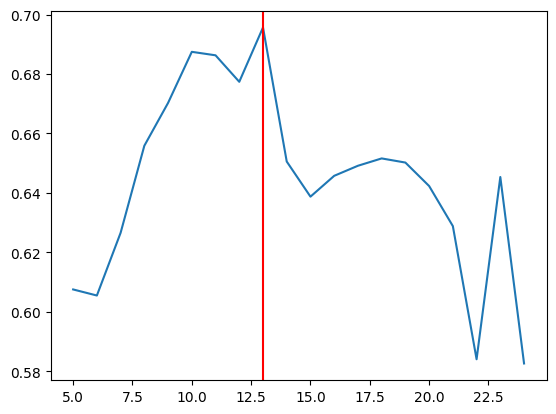

In [14]:
sns.lineplot(x=range(5,25,1), y=scores)
plt.axvline(x=best_cluster.n_clusters, ymin=0, ymax=1, color='red')

In [15]:
cluster = KMeans(n_clusters=best_cluster.n_clusters, random_state=42,init='k-means++', n_init=10)
cluster.fit(tsne_projection)
pred = cluster.predict(tsne_projection)

In [16]:
labels = ['skill_group_'+str(label) for label in best_cluster.labels_]

In [17]:
fig = px.scatter(x=tsne_projection['Dimension 1'], 
                 y=tsne_projection['Dimension 2'], 
                 text=tsne_projection.index, 
                 color=labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=1200, width=1150, title_text='Cluster')
fig.show()

In [18]:
skills_clusters  = tsne_projection.index.to_series().groupby(labels).apply(list)
skills_clusters 

with open(EXPORT_PATH+'skills_group_clusters.pkl', 'wb') as f:
    pickle.dump(skills_clusters, f)
    

## Create new features

In [19]:
skill_ohe = ohe_df.drop(columns=['DevType'])

new_features= []
for cluster , skills in skills_clusters.items():
    cluster_group = skill_ohe.droplevel(0,axis=1)[skills].sum(axis=1)
    cluster_group.name = cluster
    new_features.append(cluster_group)
    
    
new_features_df = pd.concat(new_features,axis=1)
    

## Illustration Model

In [20]:
ohe_skill = ohe_df.drop(columns=['DevType'])
ohe_skill = ohe_skill.droplevel(0,axis=1)
role_ohe = ohe_df['DevType'].copy()

combined_features = pd.concat([new_features_df,ohe_skill],axis=1)

In [21]:
combined_features

,skill_group_0,skill_group_1,skill_group_10,skill_group_11,skill_group_12,skill_group_2,skill_group_3,skill_group_4,skill_group_5,skill_group_6,...,Node.js,Pandas,Puppet,React Native,TensorFlow,Teraform,Torch/PyTorch,Unity 3D,Unreal Engine,Xamarin
0,1,0,2,0,1,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,1,0,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64457,6,0,5,3,3,2,7,2,1,3,...,0,0,0,0,0,0,0,0,0,0
64458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64459,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X_train , X_test , y_train , y_test = train_test_split(combined_features,role_ohe,test_size=0.3,random_state=42)

## Compute samples weight to deal with classes imbalance

In [23]:
weights = 1/role_ohe.sum(axis=0)
sample_weights = np.multiply(weights.values,y_train.values).mean(axis=1)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score , recall_score

In [25]:

model = MultiOutputClassifier(LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs', n_jobs=2))

model.fit(X_train,y_train,sample_weight=sample_weights)
pred = model.predict(X_test)
pred_train = model.predict(X_train)



In [26]:
print('for test data')
print('Accuracy Score: ',accuracy_score(y_test,pred))
print('F1 Score: ',f1_score(y_test,pred,average='weighted'))
print('Precision Score: ',precision_score(y_test,pred,average='weighted',zero_division=1))
print('Recall Score: ',recall_score(y_test,pred,average='weighted'))
print('---------------------------------------------------------')
print('for train data')
print('Accuracy Score: ',accuracy_score(y_train,pred_train))
print('F1 Score: ',f1_score(y_train,pred_train,average='weighted'))
print('Precision Score: ',precision_score(y_train,pred_train,average='weighted',zero_division=1))
print('Recall Score: ',recall_score(y_train,pred_train,average='weighted'))


for test data
Accuracy Score:  0.05196752675939811
F1 Score:  0.3023546489618043
Precision Score:  0.6241671435040446
Recall Score:  0.40782016579259006
---------------------------------------------------------
for train data
Accuracy Score:  0.053654536589690174
F1 Score:  0.3068293895311575
Precision Score:  0.6087213552741111
Recall Score:  0.41241826493998507


## Export new features

In [27]:
feature_path = os.path.join('../data/processed/','features_skills_clusters.pkl')
new_features_df.to_pickle(feature_path)